# CVE-2021-46529

In [1]:
import sys
sys.path.append("..")
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import glob
import matplotlib.pyplot as plt
from model.helpers import *
from model.predict import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in Data 
src = "../../data/raw/"
scenario = 'CVE-2021-46529'

#data/raw/CVE-2021-46529/attack/abundant_goodall_4310.res
attack_files = glob.glob(os.path.join(src,scenario, "attack/*.res"))
dfs_attack = []
for file in attack_files: 
    data = pd.read_csv(file, delimiter=',', index_col='timestamp', parse_dates=True)
    dfs_attack.append(data)
attack = pd.concat(dfs_attack)

attack_files = glob.glob(os.path.join(src,scenario, "normal/*.res"))
dfs_normal = []
for file in attack_files: 
    data = pd.read_csv(file, delimiter=',', index_col='timestamp', parse_dates=True)
    dfs_normal.append(data)
normal = pd.concat(dfs_normal)

In [3]:
attack = attack.fillna(0)
normal = normal.fillna(0)

In [4]:
attack.count()

cpu_usage           9203
memory_usage        9203
network_received    9203
network_send        9203
storage_read        9203
storage_written     9203
dtype: int64

In [5]:
normal.count()

cpu_usage           9212
memory_usage        9212
network_received    9212
network_send        9212
storage_read        9212
storage_written     9212
dtype: int64

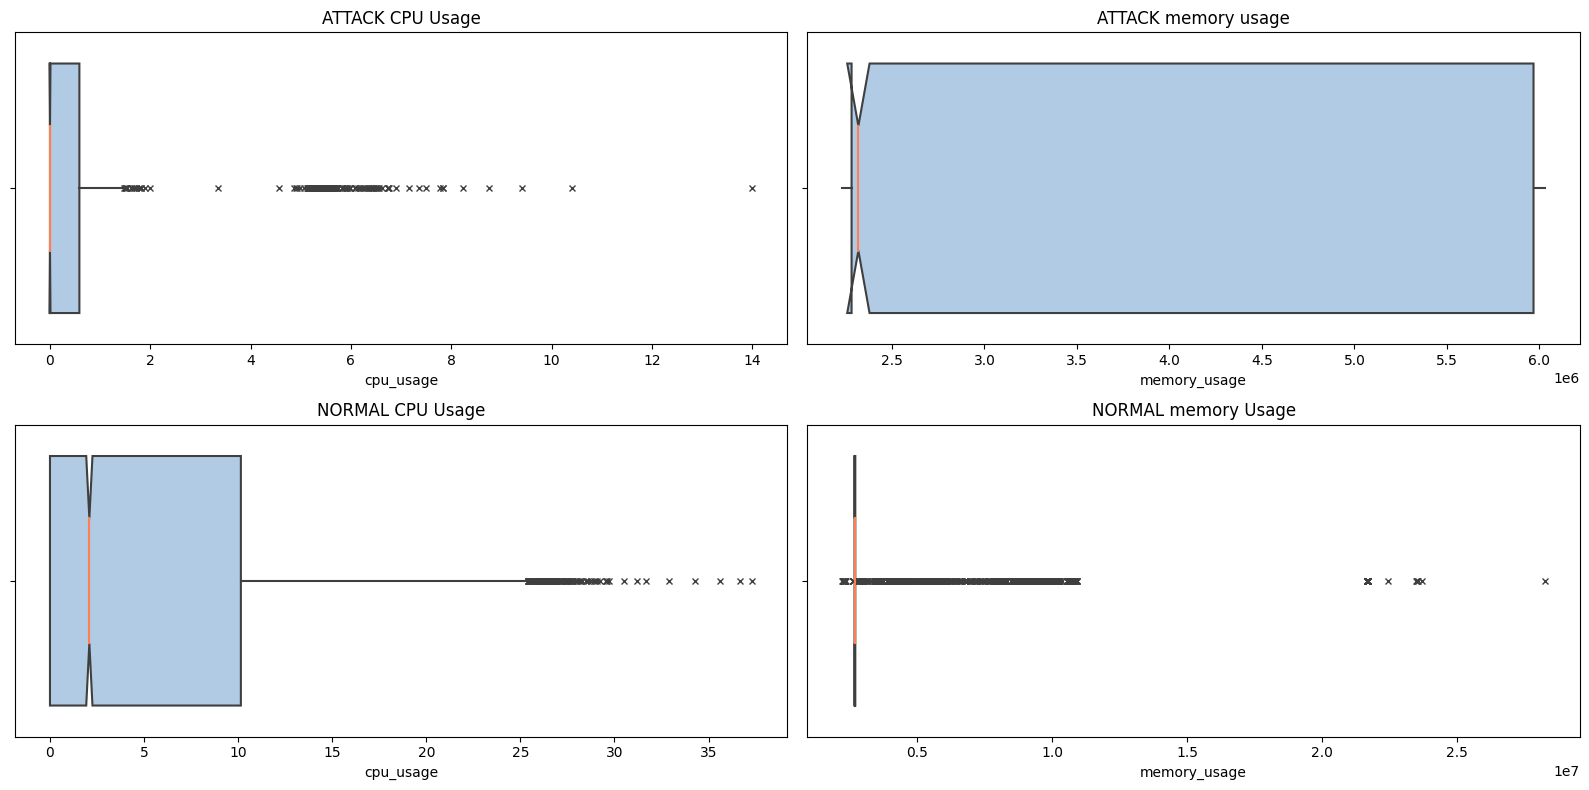

In [6]:
fig, axes = plt.subplots(2,2, sharex=False, figsize=(16,8))
sns.boxplot(data=attack, x='cpu_usage',
 notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"}, ax=axes[0,0])
axes[0,0].title.set_text("ATTACK CPU Usage")
sns.boxplot(data=attack, x='memory_usage',
 notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"}, ax=axes[0,1])
axes[0,1].title.set_text("ATTACK memory usage")
sns.boxplot(data=normal, x='cpu_usage',
 notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"}, ax=axes[1,0])
axes[1,0].title.set_text("NORMAL CPU Usage")
sns.boxplot(data=normal, x='memory_usage',
 notch=True, showcaps=False,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"}, ax=axes[1,1])
axes[1,1].title.set_text("NORMAL memory Usage")
fig.tight_layout()
plt.show()

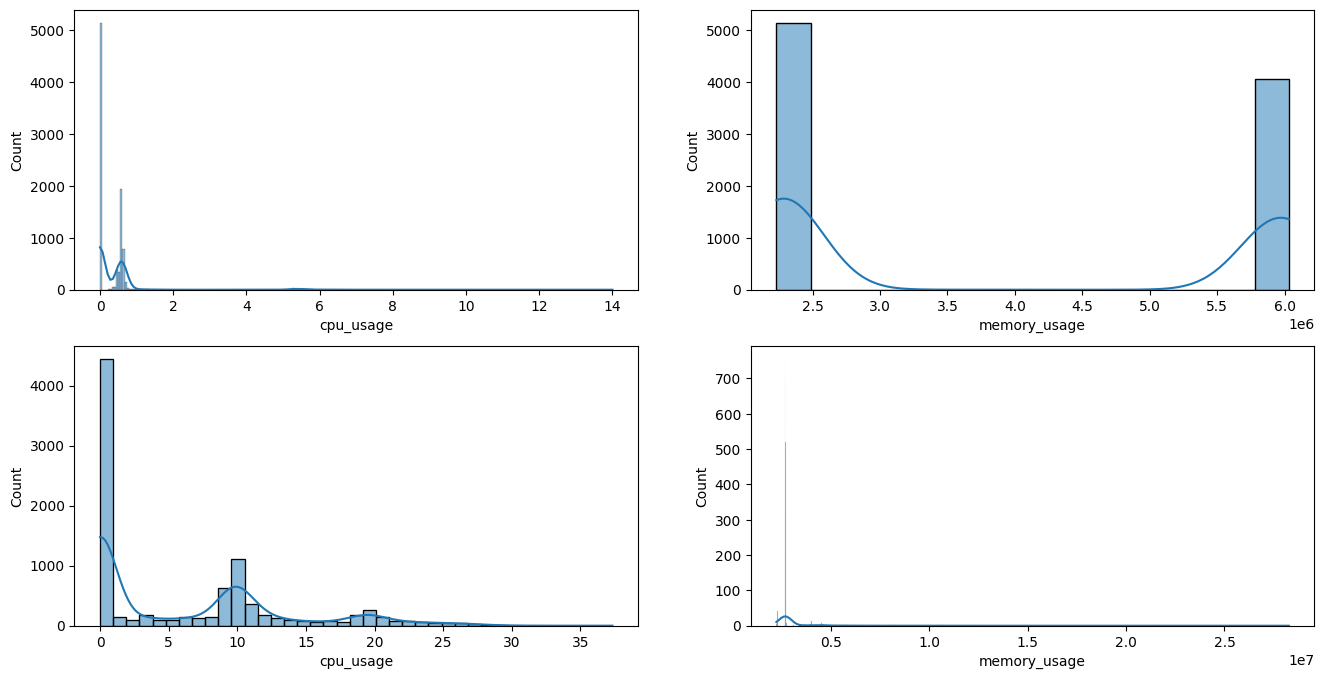

In [7]:
fig, axes = plt.subplots(2,2, sharex=False, figsize=(16,8))
# ATTACK
sns.histplot(data=attack, x='cpu_usage', kde=True, ax=axes[0,0])
sns.histplot(data=attack, x='memory_usage', kde=True, ax=axes[0,1])
# NORMAL
sns.histplot(data=normal, x='cpu_usage', kde=True, ax=axes[1,0])
sns.histplot(data=normal, x='memory_usage', kde=True, ax=axes[1,1])
plt.show()

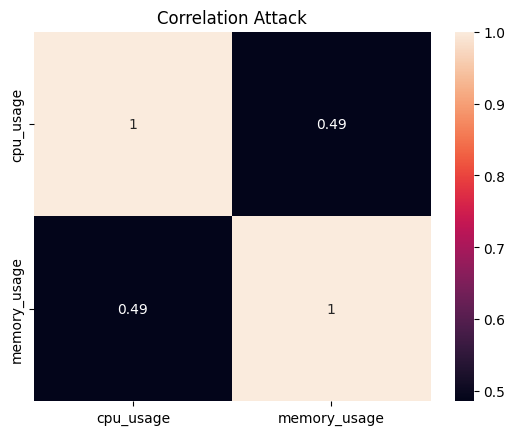

In [8]:
sns.heatmap(attack[['cpu_usage', 'memory_usage']].corr(), annot=True)
plt.title('Correlation Attack')
plt.show()

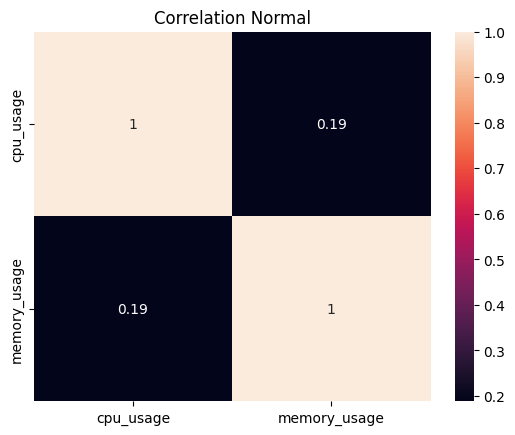

In [9]:
sns.heatmap(normal[['cpu_usage', 'memory_usage']].corr(), annot=True)
plt.title('Correlation Normal')
plt.show()

In [10]:
# add exploit column for evalutation later and shuffle data
attack['exploit'] = 1
normal['exploit'] = 0

In [11]:
normal_train, normal_test = train_test_split(normal, test_size=0.3,random_state=42)

In [12]:
print(normal_train.shape)
print(normal_test.shape)

(6448, 7)
(2764, 7)


In [13]:
attack = pd.concat([attack, normal_test])
attack.shape

(11967, 7)

In [14]:
# Set everything to requiered format
train = {scenario: normal}
test = {scenario: attack}

In [15]:
# load models
iforest = load_model(model_type='IsolationForest', train_data=train, test_data=test, scenario=scenario, contamination_rate=False)
lof = load_model(model_type='LocalOutlierFactor', train_data=train, test_data=test, scenario=scenario, contamination_rate=False)
vae = load_model(model_type='VariationalAutoencoder', train_data=train, test_data=test, scenario=scenario, contamination_rate=False)

2023-01-19 12:14:04.547903: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


288/288 [==============================] - 0s 503us/step


In [16]:
# Results
preds_iso, scores_iso, results_iforest = predict_(model=iforest, model_type='IsolationForest', data=test, scenario=scenario)
preds_lof, scores_lof, results_lof = predict_(model=lof, model_type='LocalOutlierFactor', data=test, scenario=scenario)
preds_vae, scores_vae, results_vae = predict_(model=vae, model_type='VariationalAutoencoder', data=test, scenario=scenario)

374/374 [==============================] - 0s 353us/step


In [17]:
results_iforest['IsolationForest_predictions'].value_counts()

0    7650
1    4317
Name: IsolationForest_predictions, dtype: int64

In [18]:
results_lof['LocalOutlierFactor_predictions'].value_counts()

0    10859
1     1108
Name: LocalOutlierFactor_predictions, dtype: int64

In [19]:
results_vae['VariationalAutoencoder_predictions'].value_counts()

0    11703
1      264
Name: VariationalAutoencoder_predictions, dtype: int64

In [20]:
# get values to evaluate algorithms
y_true = {'CVE-2021-46529': test['CVE-2021-46529']['exploit']}

374/374 [==============================] - 0s 367us/step


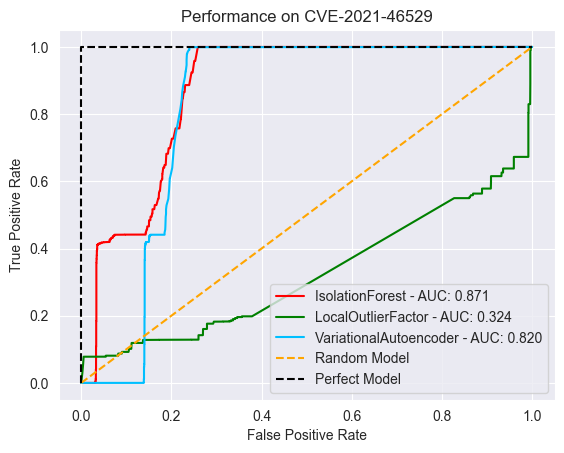

In [21]:
sns.set_style('darkgrid')
name = ['IsolationForest',  'LocalOutlierFactor', 'VariationalAutoencoder']
colors = ['red', 'green', 'deepskyblue']

algorithms = [iforest, lof, vae]
test['CVE-2021-46529'] = select_columns_for_modelling(test['CVE-2021-46529'])


fig = plt.figure()
for a, algo in enumerate(algorithms):
    algo_test = algo.decision_function(test[scenario])

    fpr_test_, tpr_test_, thresholds = roc_curve(y_true['CVE-2021-46529'], algo_test) # Kommt drauf an wie rum(?) nochmal genau reinschauen 
    algo_auc_test = auc(fpr_test_, tpr_test_)
    #J = tpr_test_ - fpr_test_
    #ix = np.argmax(J)
    #best_thresh = thresholds[ix]
    #print(str(name[a]) + ': Best Threshold %f' % (best_thresh))


    
    plt.subplot(1, 1, 1)
    plt.title('Performance on ' + scenario)
    plt.plot(fpr_test_, tpr_test_, color=colors[a], label= '{0} - AUC: {1:.3f}'.format(name[a], algo_auc_test)) #AMV: Augmented Mass Volume Function # AUC ohne 1
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    

plt.subplot(1, 1, 1)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model', color="orange")
plt.plot([0,0,1], [0, 1, 1], linestyle='--', label='Perfect Model', color="black")
plt.legend(loc=0)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))

plt.show()

In [22]:
# Confusion Matrices
c_Iso = confusion_matrix(y_true=y_true[scenario], y_pred=results_iforest['IsolationForest_predictions'])
c_Lof = confusion_matrix(y_true=y_true[scenario], y_pred=results_lof['LocalOutlierFactor_predictions'])
c_Vae = confusion_matrix(y_true=y_true[scenario], y_pred=results_vae['VariationalAutoencoder_predictions'])

In [23]:
# get rates and evaluate reuslts
cms = {'IsolationForest': c_Iso, 'LocalOutlierFactor': c_Lof, 'VariationalAutoencoder': c_Vae}
algorithms = ['IsolationForest', 'LocalOutlierFactor', 'VariationalAutoencoder']
data = {}
for algo in algorithms:
    true_negative = cms[algo][0,0]
    false_positve = cms[algo][0,1]
    false_negative = cms[algo][1,0]
    true_positve = cms[algo][1,1]
    TPR = true_positve/(true_positve+false_negative)
    # Specificity or true negative rate
    TNR = true_negative/(true_negative+false_positve) 
    # Precision or positive predictive value
    PPV = true_positve/(true_positve+false_positve)
    # Negative predictive value
    NPV = true_negative/(true_negative+false_negative)
    # Fall out or false positive rate
    FPR = false_positve/(false_positve+true_negative)
    # False negative rate
    FNR = false_negative/(true_positve+false_negative)
    # False discovery rate
    FDR = false_positve/(true_positve+false_positve)
    # Overall accuracy
    ACC = (true_positve+true_negative)/(true_positve+false_positve+false_negative+true_negative)
    # F1 Score
    F1 =  2 * (PPV * TPR) / (PPV + TPR)
    data[algo] = {
        "FPR": FPR,
        "FNR": FNR, # 
        "Recall": TPR,
        "Precision": PPV,
        "ACC": ACC,
        "F1": F1

    }
output = pd.DataFrame.from_dict(data).transpose()

In [24]:
output

,FPR,FNR,Recall,Precision,ACC,F1
IsolationForest,0.092619,0.558731,0.441269,0.940700,0.548926,0.600740
LocalOutlierFactor,0.093343,0.907639,0.092361,0.767148,0.280438,0.164872
VariationalAutoencoder,0.095514,1.000000,0.000000,0.000000,0.208908,NaN


## Contamination Rate